In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3" 

In [2]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from utils import *

2023-08-18 10:01:58.741009: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading Indian data : Contains:
- label 0 No Brick kilns images: 2000 of shape (256, 256, 3) 
- label 1 Brick kilns images: 762 of shape (256, 256, 3) 

Total 2762 images which are converted to (224, 224, 3).

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith(".jpg") or img_path.endswith(".png"):
            image = Image.open(img_path).convert('RGB')            
            image = np.array(image)
            images.append(image)
    return images

folder_path_label_0 = '/data/Indian_dataset/label_0'
folder_path_label_1 = '/data/Indian_dataset/label_1'

label0_images = load_images_from_folder(folder_path_label_0)
label1_images = load_images_from_folder(folder_path_label_1)


# Assign labels to images
label0_labels = np.zeros(len(label0_images))
label1_labels = np.ones(len(label1_images))

# Merge images and labels
all_images = np.concatenate((label0_images, label1_images), axis=0)
all_labels = np.concatenate((label0_labels, label1_labels), axis=0)

# Shuffle the data (optional, but recommended)
indices = np.arange(len(all_images))
np.random.shuffle(indices)
all_images = all_images[indices]
all_labels = all_labels[indices]

# Save to HDF5 file
with h5py.File('Indian_dataset.h5', 'w') as f:
    f.create_dataset('image', data=all_images) 
    f.create_dataset('label', data=all_labels) 

In [3]:
brick_kilns_india_path = '/data/Indian_dataset.h5'
images, labels = load_hdf5_data(brick_kilns_india_path) 

Images shape:  (2762, 256, 256, 3)
Labels shape:  (2762,)


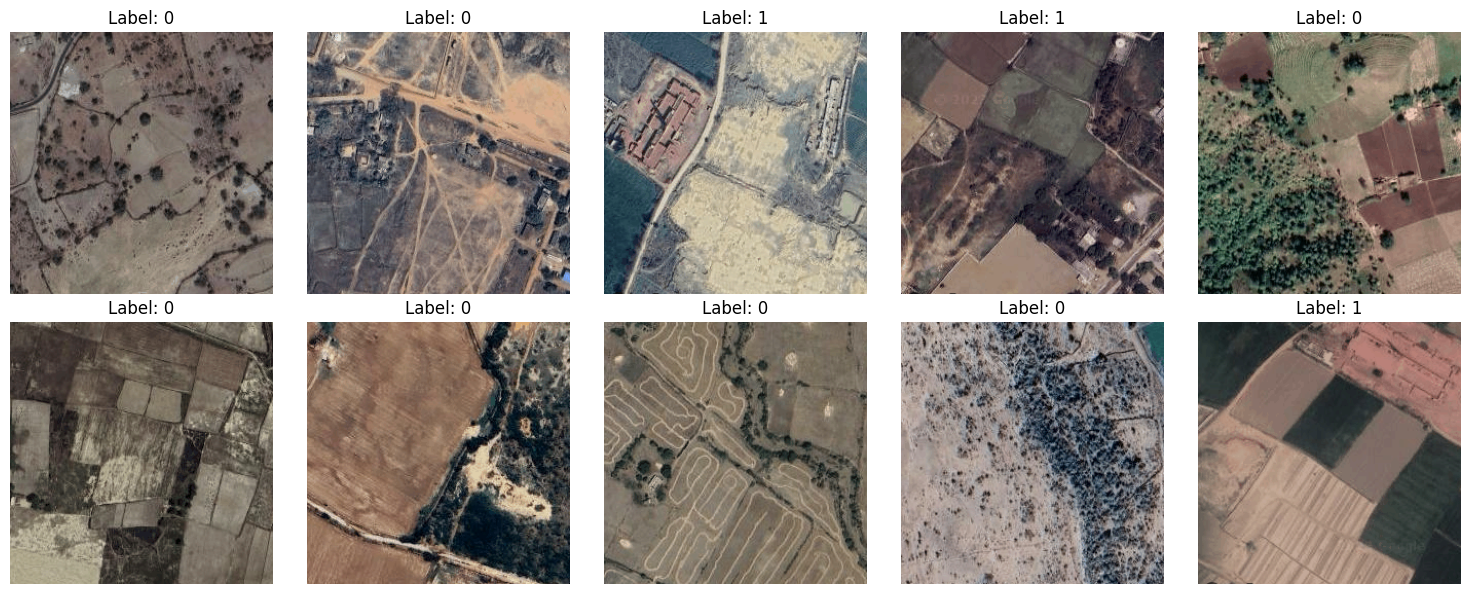

In [4]:
show_random_images_with_labels(brick_kilns_india_path, num_images=10)

spliting dataset into train-validation-test dataset using Stratify split.

In [5]:
x_train_256, x_test_265, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=0, stratify=labels)
x_train_256, x_val_265, y_train, y_val = train_test_split(x_train_256, y_train, test_size=0.2, random_state=0, stratify=y_train)
x_train_256.shape, y_train.shape,x_val_265.shape, y_val.shape,  x_test_265.shape, y_test.shape

((1767, 256, 256, 3),
 (1767,),
 (442, 256, 256, 3),
 (442,),
 (553, 256, 256, 3),
 (553,))

Converting images from (256, 256, 3) to (224, 224, 3) before passing to models

In [6]:
x_train = imgs_input_fn(x_train_256)
x_val = imgs_input_fn(x_val_265)
x_test = imgs_input_fn(x_test_265)
x_train.shape, x_val.shape, x_test.shape

2023-08-18 10:02:24.371533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78808 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


(TensorShape([1767, 224, 224, 3]),
 TensorShape([442, 224, 224, 3]),
 TensorShape([553, 224, 224, 3]))

In [7]:
class_0_train_count = np.sum(y_train == 0)
class_1_train_count = np.sum(y_train == 1)

class_0_val_count = np.sum(y_val == 0)
class_1_val_count = np.sum(y_val == 1)

class_0_test_count = np.sum(y_test == 0)
class_1_test_count = np.sum(y_test == 1)

print('Total in training set:', len(y_train))
print("Class 0 in training set:", class_0_train_count)
print("Class 1 in training set:", class_1_train_count)

print('Total in validation set:', len(y_val))
print("Class 0 in validation set:", class_0_val_count)
print("Class 1 in validation set:", class_1_val_count)

print('Total in test set:', len(y_test))
print("Class 0 in test set:", class_0_test_count)
print("Class 1 in test set:", class_1_test_count)

Total in training set: 1767
Class 0 in training set: 1280
Class 1 in training set: 487
Total in validation set: 442
Class 0 in validation set: 320
Class 1 in validation set: 122
Total in test set: 553
Class 0 in test set: 400
Class 1 in test set: 153


# Densenet 

In [8]:
model_densenet = densenet_model(learning_rate=0.00002)
model_densenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [9]:
num_epochs = 100 #  best epoch: 30.

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model_densenet.fit(x_train, y_train, batch_size=128, epochs=num_epochs, verbose=1, 
                      validation_data=(x_val, y_val) ,callbacks=[early_stopping])
# Evaluate the model
train_loss, train_acc = model_densenet.evaluate(x_train, y_train)
test_loss, test_acc = model_densenet.evaluate(x_test, y_test)
print('Train accuracy: ', train_acc) 
print('Test accuracy: ', test_acc) 

Epoch 1/100


2023-08-18 07:37:54.604029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8903
2023-08-18 07:37:56.480757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-18 07:37:56.512694: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f432549ad90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-18 07:37:56.512756: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-08-18 07:37:56.517836: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-18 07:37:56.664409: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

14/14 [==============================] - 73s 909ms/step - loss: 0.5046 - acc: 0.7589 - val_loss: 0.4495 - val_acc: 0.8507
Epoch 2/100
14/14 [==============================] - 4s 291ms/step - loss: 0.2374 - acc: 0.9349 - val_loss: 0.3576 - val_acc: 0.8643
Epoch 3/100
14/14 [==============================] - 4s 278ms/step - loss: 0.1401 - acc: 0.9785 - val_loss: 0.3173 - val_acc: 0.8756
Epoch 4/100
14/14 [==============================] - 4s 279ms/step - loss: 0.0954 - acc: 0.9853 - val_loss: 0.2920 - val_acc: 0.8891
Epoch 5/100
14/14 [==============================] - 4s 271ms/step - loss: 0.0629 - acc: 0.9932 - val_loss: 0.2489 - val_acc: 0.9027
Epoch 6/100
14/14 [==============================] - 4s 277ms/step - loss: 0.0456 - acc: 0.9972 - val_loss: 0.2198 - val_acc: 0.9118
Epoch 7/100
14/14 [==============================] - 4s 274ms/step - loss: 0.0339 - acc: 0.9960 - val_loss: 0.2036 - val_acc: 0.9186
Epoch 8/100
14/14 [==============================] - 4s 277ms/step - loss: 0.025

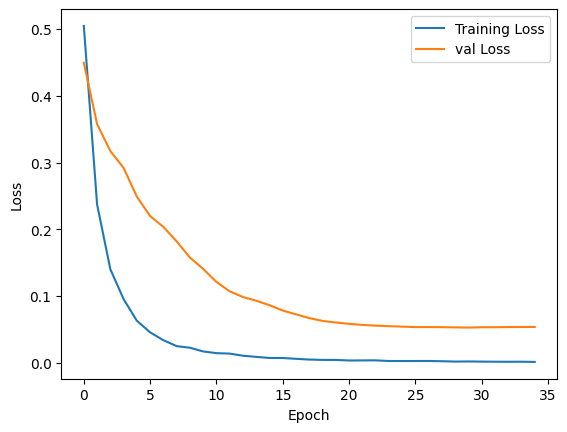

In [11]:
# Show loss vs. epochs  loss: 0.0030 - acc: 1.0000 - val_loss: 0.0379 - val_acc: 0.9864
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Prediction on Indian test

18/18 [==============================] - 2s 20ms/step


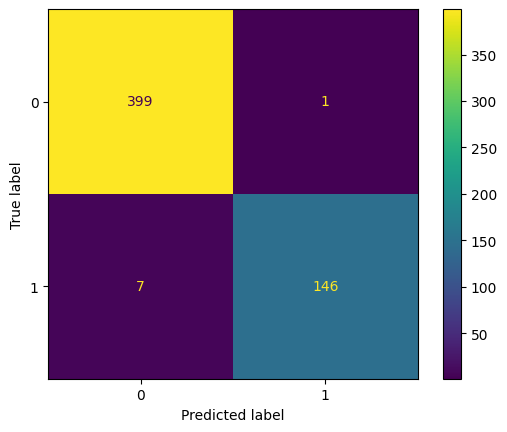

Precision:  0.9931972789115646
Recall:  0.954248366013072
F1 score:  0.9733333333333335


In [12]:
y_pred_prob = model_densenet.predict(x_test)
y_pred_labels = np.round(y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()
precision = precision_score(y_test, y_pred_labels)
print("Precision: ", precision)
recall = recall_score(y_test, y_pred_labels)
print("Recall: ", recall)
f1 = f1_score(y_test, y_pred_labels)
print("F1 score: ", f1)

# VGG

In [8]:
model_vgg = VGG_16_transfer_model_author(learning_rate=0.00002)
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 512)        0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                        

In [9]:
num_epochs = 100 # best epoch 4

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model_vgg.fit(x_train, y_train, batch_size=128, epochs=num_epochs, verbose=1, 
                      validation_data=(x_val, y_val), callbacks=[early_stopping])
# Evaluate the model
train_loss, train_acc = model_vgg.evaluate(x_train, y_train)
test_loss, test_acc = model_vgg.evaluate(x_test, y_test)
print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)


Epoch 1/100


2023-08-18 10:02:33.356842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8903
2023-08-18 10:02:36.219292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-18 10:02:36.266026: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f0a1db91660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-18 10:02:36.266089: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-08-18 10:02:36.271163: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-18 10:02:36.420734: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

14/14 [==============================] - 44s 2s/step - loss: 0.3195 - acc: 0.8625 - val_loss: 0.1632 - val_acc: 0.9367
Epoch 2/100
14/14 [==============================] - 16s 1s/step - loss: 0.1230 - acc: 0.9502 - val_loss: 0.1049 - val_acc: 0.9661
Epoch 3/100
14/14 [==============================] - 6s 418ms/step - loss: 0.0652 - acc: 0.9762 - val_loss: 0.0713 - val_acc: 0.9751
Epoch 4/100
14/14 [==============================] - 4s 255ms/step - loss: 0.0306 - acc: 0.9915 - val_loss: 0.0683 - val_acc: 0.9819
Epoch 5/100
14/14 [==============================] - 3s 238ms/step - loss: 0.0169 - acc: 0.9938 - val_loss: 0.0719 - val_acc: 0.9774
Epoch 6/100
14/14 [==============================] - 3s 235ms/step - loss: 0.0149 - acc: 0.9949 - val_loss: 0.1134 - val_acc: 0.9638
Epoch 7/100
14/14 [==============================] - 3s 230ms/step - loss: 0.0268 - acc: 0.9892 - val_loss: 0.0973 - val_acc: 0.9774
Epoch 8/100
14/14 [==============================] - 3s 237ms/step - loss: 0.0153 - a

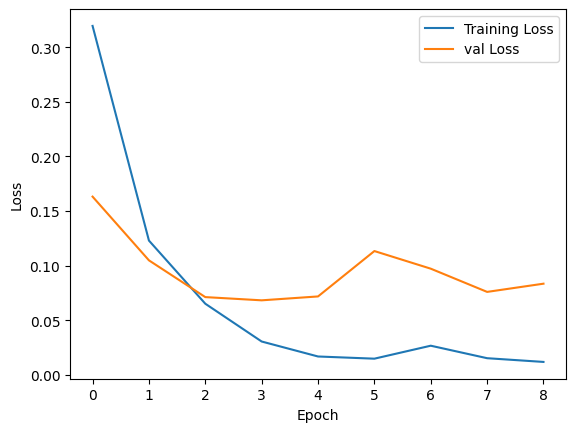

In [10]:
# Show loss vs. epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend() 
plt.show() 

Prediction on indian test

18/18 [==============================] - 0s 19ms/step


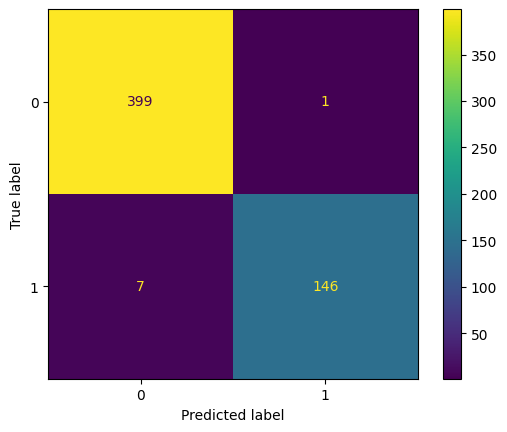

Precision:  0.9931972789115646
Recall:  0.954248366013072
F1 score:  0.9733333333333335


In [11]:
y_pred_prob = model_vgg.predict(x_test)
y_pred_labels = np.round(y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()
precision = precision_score(y_test, y_pred_labels)
print("Precision: ", precision)
recall = recall_score(y_test, y_pred_labels)
print("Recall: ", recall)
f1 = f1_score(y_test, y_pred_labels)
print("F1 score: ", f1)

# Resnet

In [12]:
model_resnet = resnet_model(learning_rate=0.00002)
model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 average_pooling2d_1 (Averag  (None, 1, 1, 2048)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 2049      
                                                      

In [13]:
num_epochs = 100 # best epoch: 26.

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model_resnet.fit(x_train, y_train, batch_size=128, epochs=num_epochs, verbose=1, 
                      validation_data=(x_val, y_val), callbacks=[early_stopping])
# Evaluate the model 
train_loss, train_acc = model_resnet.evaluate(x_train, y_train)
test_loss, test_acc = model_resnet.evaluate(x_test, y_test)
print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc) 

Epoch 1/100


14/14 [==============================] - 41s 595ms/step - loss: 0.4117 - acc: 0.8223 - val_loss: 0.2798 - val_acc: 0.9208
Epoch 2/100
14/14 [==============================] - 3s 222ms/step - loss: 0.1256 - acc: 0.9740 - val_loss: 0.1497 - val_acc: 0.9570
Epoch 3/100
14/14 [==============================] - 3s 215ms/step - loss: 0.0460 - acc: 0.9938 - val_loss: 0.1093 - val_acc: 0.9593
Epoch 4/100
14/14 [==============================] - 3s 208ms/step - loss: 0.0219 - acc: 0.9983 - val_loss: 0.0969 - val_acc: 0.9638
Epoch 5/100
14/14 [==============================] - 3s 217ms/step - loss: 0.0098 - acc: 1.0000 - val_loss: 0.0837 - val_acc: 0.9638
Epoch 6/100
14/14 [==============================] - 3s 211ms/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.0774 - val_acc: 0.9661
Epoch 7/100
14/14 [==============================] - 3s 181ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.0737 - val_acc: 0.9683
Epoch 8/100
14/14 [==============================] - 3s 211ms/step - loss: 0.003

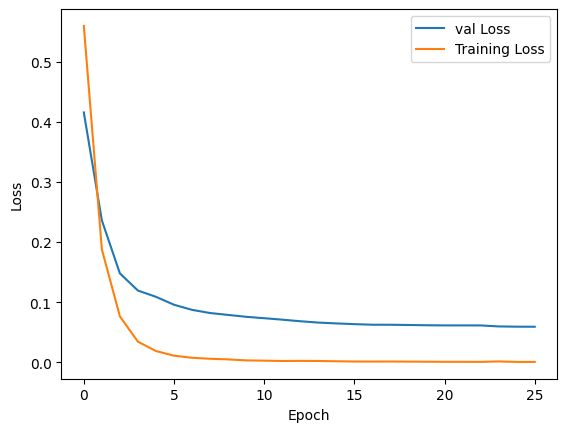

In [24]:
# Show loss vs. epochs
plt.plot(history.history['val_loss'], label='val Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Predict on Indian test set

18/18 [==============================] - 1s 14ms/step


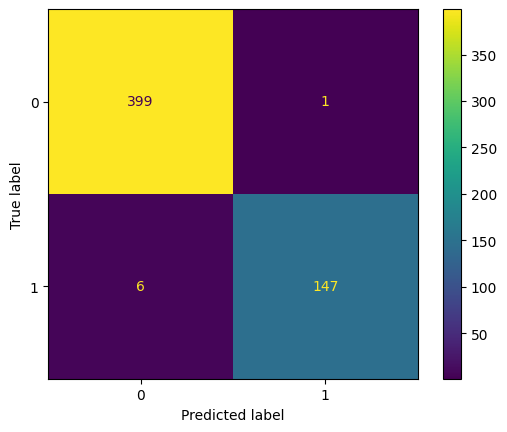

Precision:  0.9932432432432432
Recall:  0.9607843137254902
F1 score:  0.9767441860465117


In [14]:
y_pred_prob = model_resnet.predict(x_test)
y_pred_labels = np.round(y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()
precision = precision_score(y_test, y_pred_labels)
print("Precision: ", precision)
recall = recall_score(y_test, y_pred_labels)
print("Recall: ", recall)
f1 = f1_score(y_test, y_pred_labels)
print("F1 score: ", f1)

# EfficientnetBo

In [15]:
model_efficientnetb0 = efficientnet_b0_model(learning_rate=0.00002)
model_efficientnetb0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                      

In [16]:
num_epochs = 100 # best epoch: 36.

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

history = model_efficientnetb0.fit(x_train, y_train, batch_size=128, epochs=num_epochs, verbose=1, 
                       validation_data=(x_val, y_val) , callbacks =[early_stopping]) 
# Evaluate the model
train_loss, train_acc = model_efficientnetb0.evaluate(x_train, y_train)
test_loss, test_acc = model_efficientnetb0.evaluate(x_test, y_test)
print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc) 

Epoch 1/100


2023-08-18 08:55:16.220243: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


14/14 [==============================] - 41s 381ms/step - loss: 0.6996 - acc: 0.5020 - val_loss: 0.6993 - val_acc: 0.5090
Epoch 2/100
14/14 [==============================] - 4s 273ms/step - loss: 0.6000 - acc: 0.7131 - val_loss: 0.6334 - val_acc: 0.6561
Epoch 3/100
14/14 [==============================] - 4s 279ms/step - loss: 0.5098 - acc: 0.8596 - val_loss: 0.5554 - val_acc: 0.7873
Epoch 4/100
14/14 [==============================] - 4s 254ms/step - loss: 0.4304 - acc: 0.9168 - val_loss: 0.4704 - val_acc: 0.8937
Epoch 5/100
14/14 [==============================] - 4s 268ms/step - loss: 0.3534 - acc: 0.9377 - val_loss: 0.3857 - val_acc: 0.9299
Epoch 6/100
14/14 [==============================] - 4s 253ms/step - loss: 0.2860 - acc: 0.9610 - val_loss: 0.3093 - val_acc: 0.9525
Epoch 7/100
14/14 [==============================] - 4s 285ms/step - loss: 0.2309 - acc: 0.9768 - val_loss: 0.2445 - val_acc: 0.9570
Epoch 8/100
14/14 [==============================] - 4s 284ms/step - loss: 0.182

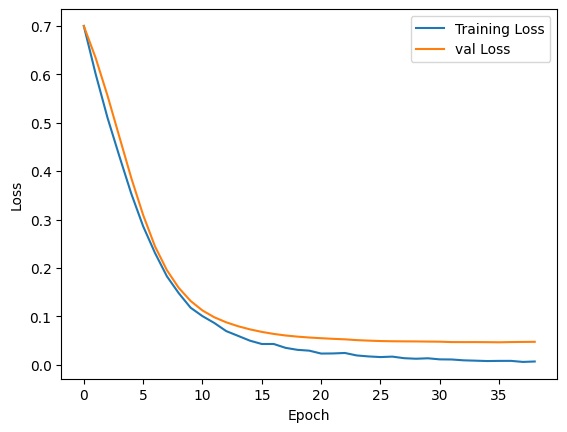

In [17]:
# Show loss vs. epochs 0.9855334758758545
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Predict on Indian test dataset

18/18 [==============================] - 1s 15ms/step


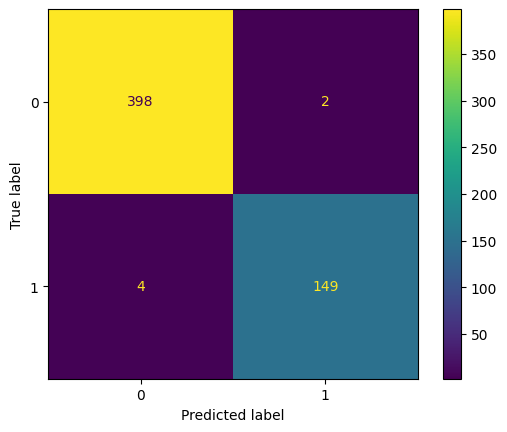

Precision:  0.9867549668874173
Recall:  0.9738562091503268
F1 score:  0.9802631578947368


In [18]:
y_pred_prob = model_efficientnetb0.predict(x_test)
y_pred_labels = np.round(y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()
precision = precision_score(y_test, y_pred_labels)
print("Precision: ", precision)
recall = recall_score(y_test, y_pred_labels)
print("Recall: ", recall)
f1 = f1_score(y_test, y_pred_labels)
print("F1 score: ", f1)